In [1]:
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ai4i2020.csv')
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [3]:
report = ydata_profiling.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df[df['Type']=='H'].head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
10   11     H29424    H                298.4                    308.9   
11   12     H29425    H                298.6                    309.1   
18   19     H29432    H                298.8                    309.2   
20   21     H29434    H                298.9                    309.3   
27   28     H29441    H                299.1                    309.4   

    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
10                    1782         23.9               24                0   
11                    1423         44.3               29                0   
18                    1306         54.5               50                0   
20                    1375         42.7               58                0   
27                    1811         24.6               77                0   

    TWF  HDF  PWF  OSF  RNF  
10    0    0    0    0    0  
11    0    0    0    0    0  
18    0    0    0    0    0  
20    0    0    0    0    0  
27    0    0    0    0    0

Variables <code>UDI</code> and <code>Product ID</code> do not seem to have any predictive power. <br>
- <code>UDI</code> is just like the index number of the data.
- <code>Product ID</code> is the prefix of the product. Example, <code>Product ID = H29424</code> for <code>Type = H</code>.

In [5]:
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

Variables <code>TWF</code>, <code>HDF</code>, <code>PWF</code>, <code>OSF</code> and <code>RNF</code> are heavily imbalanced against the "No Failure" feature in the data, that is, <code>Machine failure = 0</code>. <br> 

The problem at hand involves classifying whether a machine will fail based on specific numerical values, making it a binary classification task. However, the dataset is imbalanced, leading to a modification of the problem as a multiclass classification task.

In [6]:
df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

It can be observed that there are 2 columns, namely <code>Rotational speed [rpm]</code> and <code>Torque [Nm]</code>. We can create a new variable out them, <code>Power</code>. <br>

$$ Power = Torque * rpm $$

In [7]:
df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

The <code>Type</code> variable has 3 different values. These denote the quality of the machine.<br>

- L = Low
- M = Medium
- H = High

We have the option to convert them into dummy variables as the quality could potentially influence the prediction of machine maintenance.

In [8]:
df['Type'] = df['Type'].map({
    'L':0,
    'M':1,
    'H':2
})

In [9]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     1                298.1                    308.6                    1551   
1     0                298.2                    308.7                    1408   
2     0                298.1                    308.5                    1498   
3     0                298.2                    308.6                    1433   
4     0                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure    Power  
0         42.8                0                0  66382.8  
1         46.3                3                0  65190.4  
2         49.4                5                0  74001.2  
3         39.5                7                0  56603.5  
4         40.0                9                0  56320.0

As observed earlier, there is a big imbalance in the data. We need to look into it and sample data accordingly.

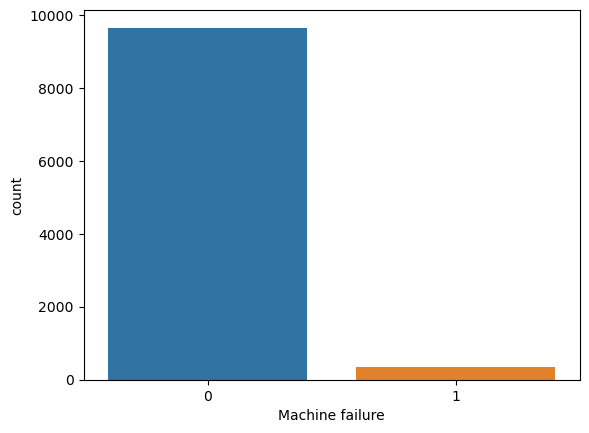

In [10]:
%matplotlib inline

sns.countplot(data=df, x='Machine failure')
plt.show()

In [11]:
len(df[df['Machine failure']==0])

9661

In [12]:
10000 - 9661

339

Given the enormous disparity in class sizes (9661 vs. 339), combining oversampling approaches may be advantageous. ADASYN could tweak the synthetic samples depending on ADASYN's adaptable nature.

In [13]:
from imblearn.over_sampling import RandomOverSampler, ADASYN

In [14]:
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']

In [15]:
random_oversampler = RandomOverSampler()
adasyn = ADASYN()

# Apply RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

# Apply ADASYN
X_resampled_final, y_resampled_final = adasyn.fit_resample(X_resampled, y_resampled)


Split the data.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_final, y_resampled_final, test_size=0.2, random_state=101)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import joblib

In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model 1: Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1928
           1       0.99      1.00      1.00      1937

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



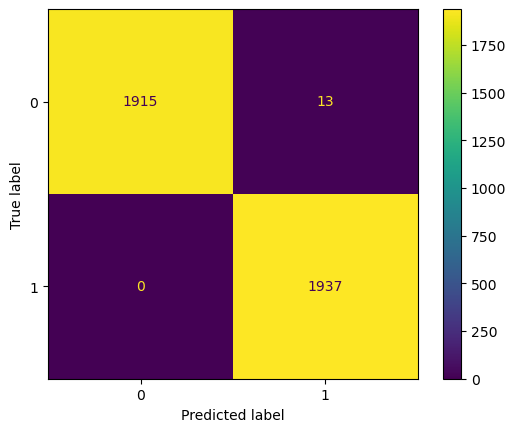

In [22]:
# Make predictions on the test set
y_pred = rfc.predict(X_test_scaled)

# Generate the classification report and confusion matrix
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
accuracy_score_rcf = accuracy_score(y_test, y_pred)

print(report)

disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Model 2: AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

In [24]:
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier()

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1928
           1       0.93      0.94      0.93      1937

    accuracy                           0.93      3865
   macro avg       0.93      0.93      0.93      3865
weighted avg       0.93      0.93      0.93      3865



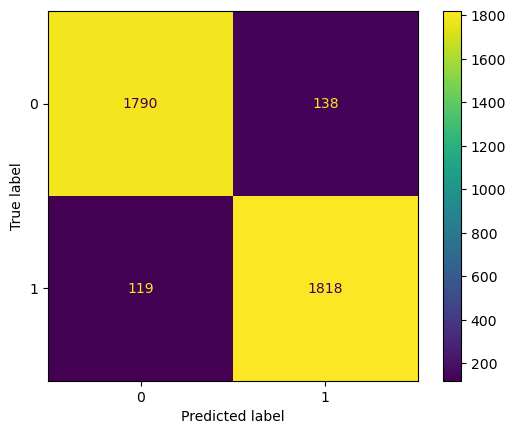

In [25]:
# Make predictions on the test set
y_pred = ada.predict(X_test_scaled)

# Generate the classification report and confusion matrix
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
accuracy_score_ada = accuracy_score(y_test, y_pred)

print(report)

disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Model 3: GradientBoost

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1928
           1       0.96      0.99      0.97      1937

    accuracy                           0.97      3865
   macro avg       0.97      0.97      0.97      3865
weighted avg       0.97      0.97      0.97      3865



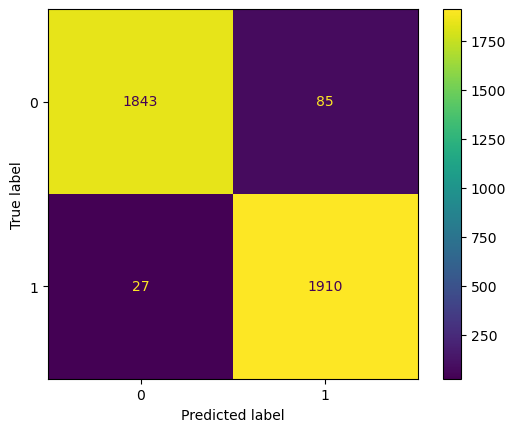

In [28]:
# Make predictions on the test set
y_pred = gbc.predict(X_test_scaled)

# Generate the classification report and confusion matrix
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
accuracy_score_gbc = accuracy_score(y_test, y_pred)

print(report)

disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Let's compare the accuracy scores of each algorithm.

In [29]:
print(f'''
      Random Forest accuracy score: {accuracy_score_rcf}\n
      AdaBoost accuracy score: {accuracy_score_ada}\n
      GradientBoost accuracy score: {accuracy_score_gbc}\n
      ''')


      Random Forest accuracy score: 0.9966364812419146

      AdaBoost accuracy score: 0.9335058214747736

      GradientBoost accuracy score: 0.9710219922380336

      


Taking a look at the important features.

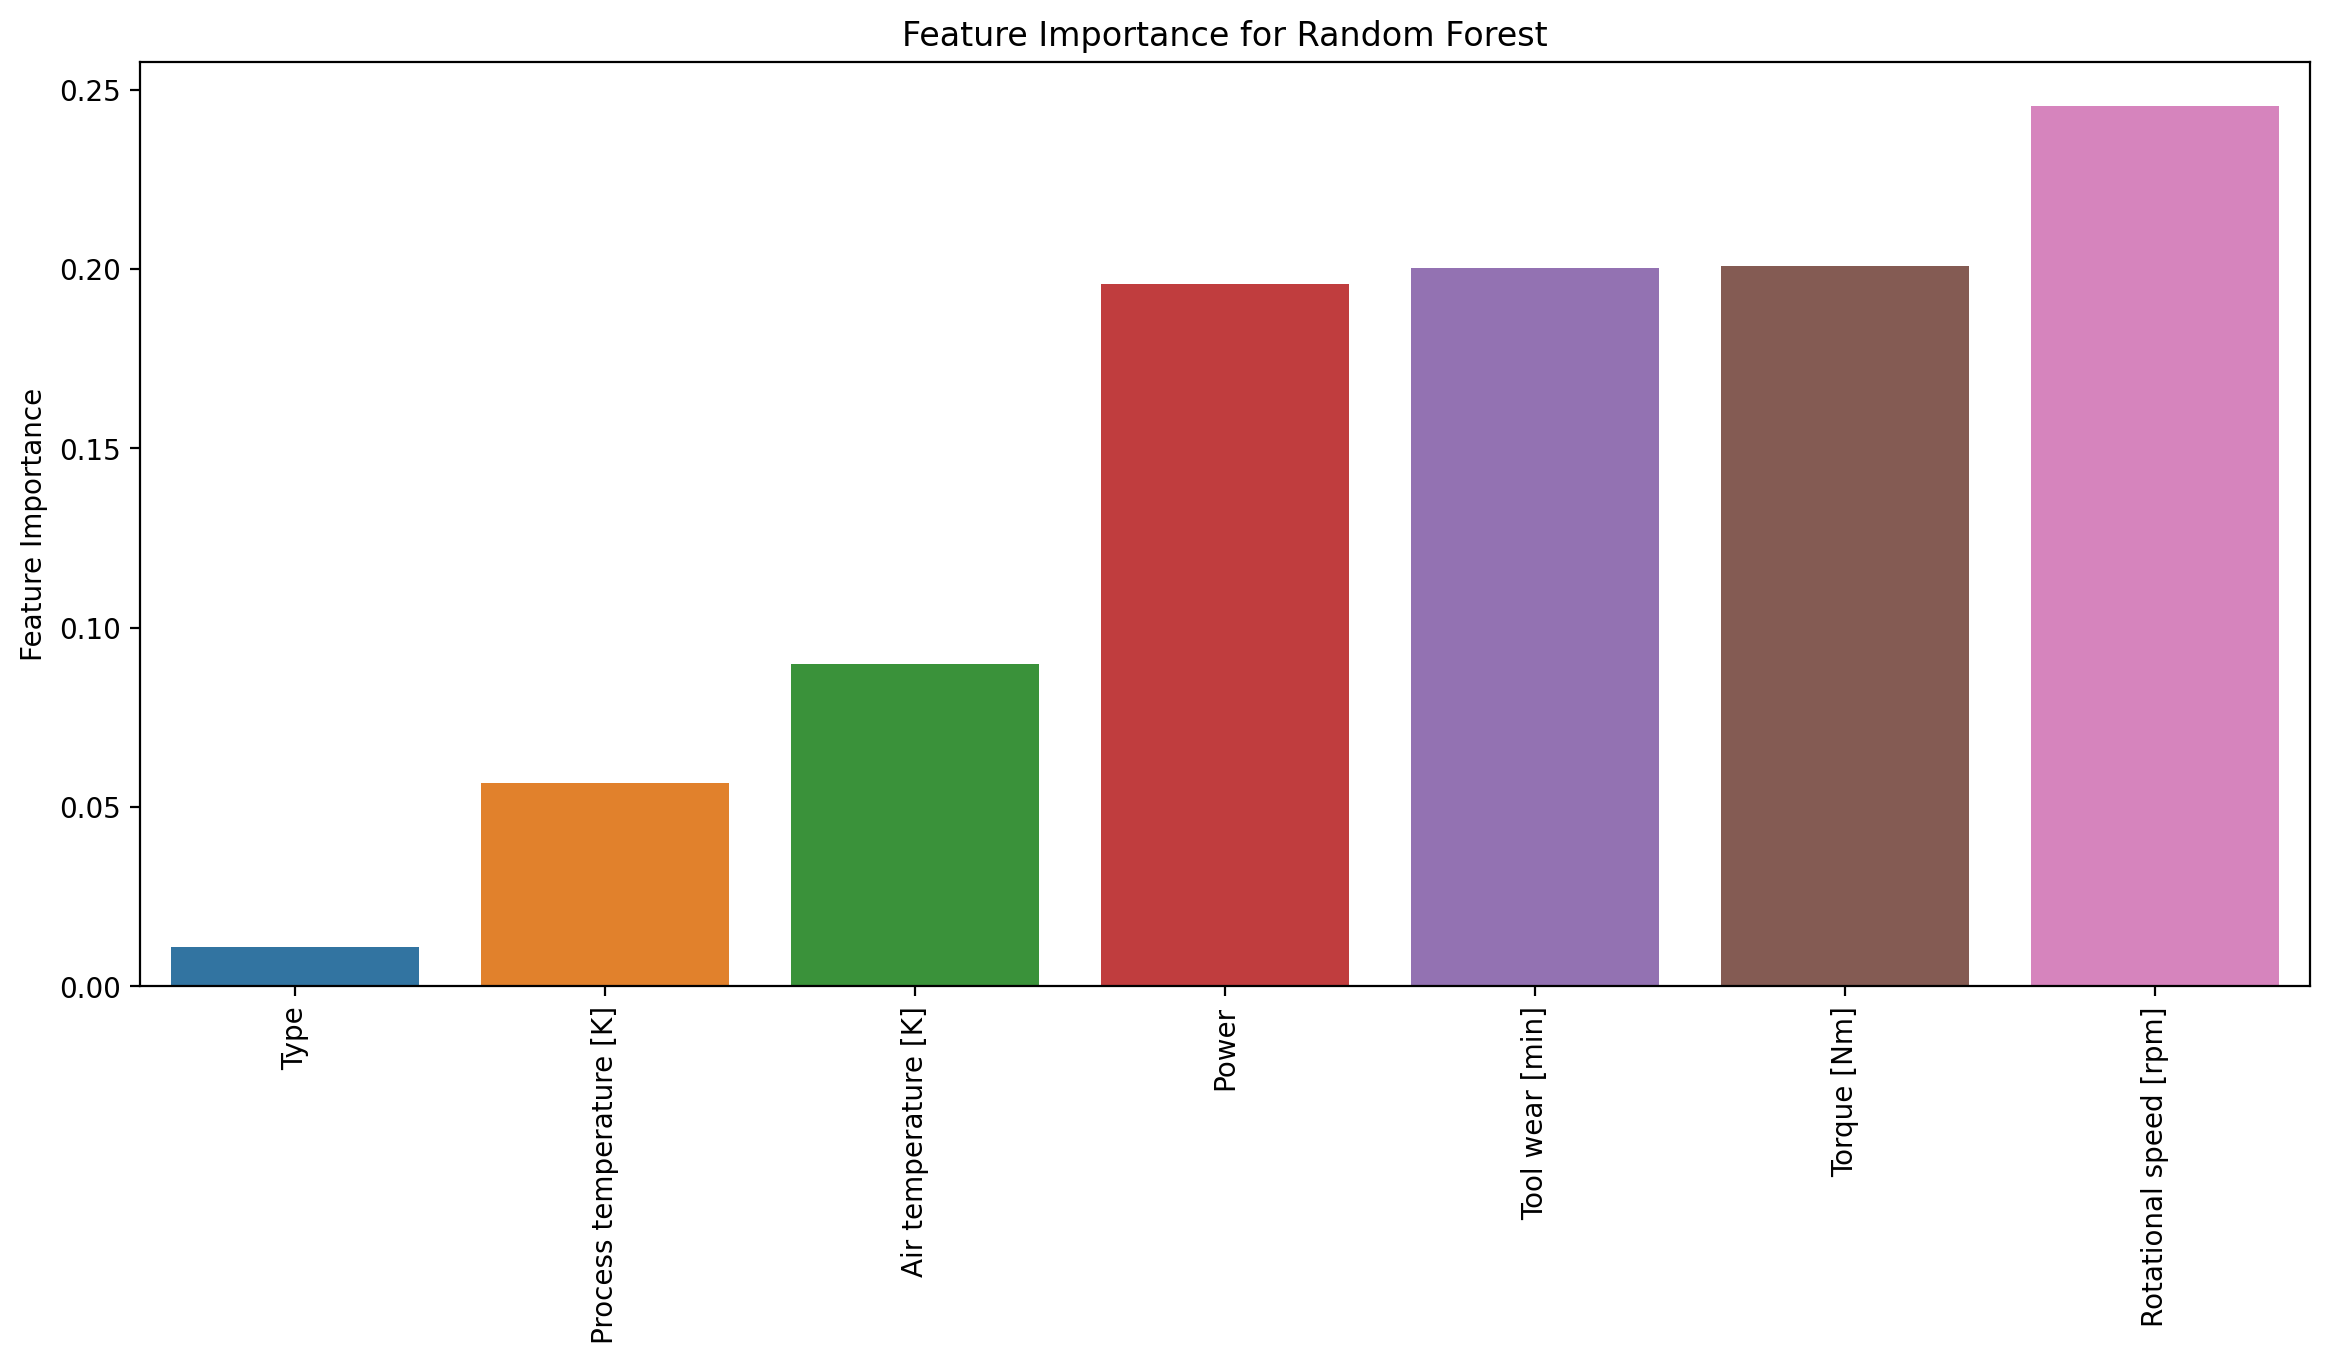

In [30]:
imp_feats = pd.DataFrame(data=rfc.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance')
plt.xticks(rotation=90)
plt.title('Feature Importance for Random Forest')
plt.savefig('feat_imp.png')
plt.show()

The top 3 features for prediction are <code>Rotational speed [rpm]</code>, <code>Torque [Nm]</code> and <code>Total wear [min]</code>. 

Random Forest perform the best out of all the algorithms. Now, we train all the data on the RandomForestClassifier.

In [31]:
best_model = rfc.fit(X,y)

In [32]:
joblib.dump(best_model, 'rfc_model.joblib')

['rfc_model.joblib']

In [33]:
X.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Power'],
      dtype='object')

In [34]:
new_data = {
    'Type': 1,
    'Air temperature [K]': 300,
    'Process temperature [K]': 310,
    'Rotational speed [rpm]': 1538,
    'Torque [Nm]': 20,
    'Tool wear [min]': 150,
    'Power': 10000   
}

# Create a DataFrame from the new data
new_data_df = pd.DataFrame([new_data])

# Make predictions using the trained model
predictions = best_model.predict(new_data_df)

# Print the predictions
print(predictions)

[1]
